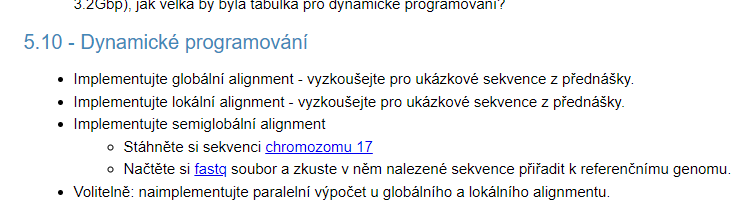

In [1]:
import random
import numpy as np
import pandas as pd
import time

In [2]:
ALPHABET = ['A', 'C', 'G', 'T']

In [3]:
def delta(a, b):
    return 0 if a == b else 1

In [4]:
def formula_calc(M, row_i, col_i, x, y, pen, maximum=False):    
    x_char = x[row_i - 1]
    y_char = y[col_i - 1]
    
    x_exists = x_char in list(pen.index)
    y_exists = y_char in list(pen.columns)
    
    indel = pen.iloc[-1, -1]
    
    upper = M[row_i - 1, col_i] + pen[x_char]['-'] if x_exists else indel
    left = M[row_i, col_i - 1] + pen['-'][y_char] if y_exists else indel
    upper_left = M[row_i - 1, col_i - 1] + pen[x_char][y_char] if x_exists and y_exists else indel
    
    #print('Choice', upper, left, upper_left, maximum, x_char, y_char)
    value = np.max([upper, left, upper_left, 0]) if maximum else np.min([upper, left, upper_left])
    #print('Value', value)
    
    return value 

In [5]:
"""
    x - index string
    y - columns string
    init(matrix, pen_f)
    pen_f
"""
def edit_distance(x, y, formula_calc, init=None, penalization_func=None, verbose=False, maximum=False):
    
    tic = time.time()
    
    l_a = len(x)
    l_b = len(y)
    
    e_l_a = l_a + 1
    e_l_b = l_b + 1
    
    M = np.zeros(shape=(e_l_a, e_l_b), dtype=np.int8)
    
    
    if verbose:
        print(f'Current input is:\n \n\tx={x}\n\ty={y}\n')
    
    
    #Doplníme hodnoty D[0, i] = i a D[j, 0] = j
    
    M = init(M, penalization_func, x, y)
        
    #Dle vyznačeného směru dopočítáme do tabulky hodnoty:
    
    for row_i in range(1, e_l_a):
        for col_i in range(1, e_l_b):
            M[row_i, col_i] = formula_calc(M, row_i, col_i, x, y, penalization_func, maximum)
    
    tac = time.time()
    
    runtime = tac - tic
    
    empty = list('e')
    indicies = empty+list(x)
    columns = empty+list(y)
    
    if verbose:
        print('Current result is:\n')
        print(pd.DataFrame(M, index=indicies, columns=columns))
        print(f'\nRunning time is:\n\n {runtime}')

    return (M, runtime)

# Implementujte globální alignment - vyzkoušejte pro ukázkové sekvence z přednášky

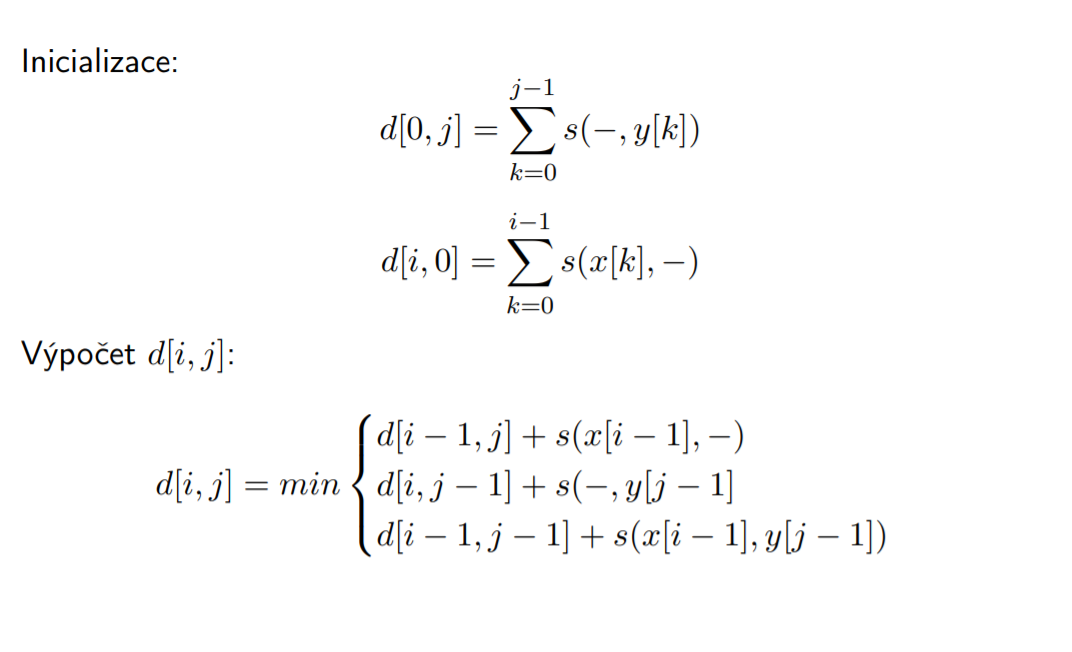

In [6]:
def is_tranzice(x, y):
    return (x == 'A' and y == 'G') or (x == 'G' and y == 'A') or (x == 'C' and y == 'T') or (x == 'T' and y == 'C')  

In [7]:
def create_pen_function(tranzice, transverze, i_d):
    
    size = len(ALPHABET) + 1
    k = ALPHABET+['-']
    pen = np.zeros(shape=(size, size))
    df = pd.DataFrame(pen, index=k, columns=k)
    
    for index, row in df.iterrows():
        for c in df.columns:
            if index == c:
                continue
                
            if is_tranzice(index, c):
                df[index][c] = tranzice
            else:
                df[index][c] = transverze
                
    pen[:, -1] = i_d
    pen[-1, :] = i_d
        
    return df

In [8]:
def init_global(M, pen, x, y):
    row_size = M.shape[0]
    column_size = M.shape[1]
    
    M[0, 0] = 0
    for i in range(1, row_size):
        current_char = x[i-1]
        M[i, 0] = pen[current_char]['-'] + M[i-1, 0]
        
    for j in range(1, column_size):
        current_char = y[j-1]
        M[0, j] = pen['-'][current_char] + M[0, j-1]
    
    return M

In [9]:
def init_local(M, pen, x, y):
    M[0, 0:] = 0
    M[0:, 0] = 0
    return M

In [10]:
pen = create_pen_function(2, 4, 8)
pen

,A,C,G,T,-
A,0.0,4.0,2.0,4.0,8.0
C,4.0,0.0,4.0,2.0,8.0
G,2.0,4.0,0.0,4.0,8.0
T,4.0,2.0,4.0,0.0,8.0
-,8.0,8.0,8.0,8.0,8.0


In [11]:
y = 'TATGTCATGC'
x = 'TACGTCAGC'
M, m = edit_distance(x, y, formula_calc, init_global, pen, False);
pd.DataFrame(M, index=(['e']+list(x)), columns=(['e'] + list(y)))

,e,T,A,T,G,T,C,A,T,G,C
e,0,8,16,24,32,40,48,56,64,72,80
T,8,0,8,16,24,32,40,48,56,64,72
A,16,8,0,8,16,24,32,40,48,56,64
C,24,16,8,2,10,18,24,32,40,48,56
G,32,24,16,10,2,10,18,26,34,40,48
T,40,32,24,16,10,2,10,18,26,34,42
C,48,40,32,24,18,10,2,10,18,26,34
A,56,48,40,32,26,18,10,2,10,18,26
G,64,56,48,40,32,26,18,10,6,10,18
C,72,64,56,48,40,34,26,18,12,10,10


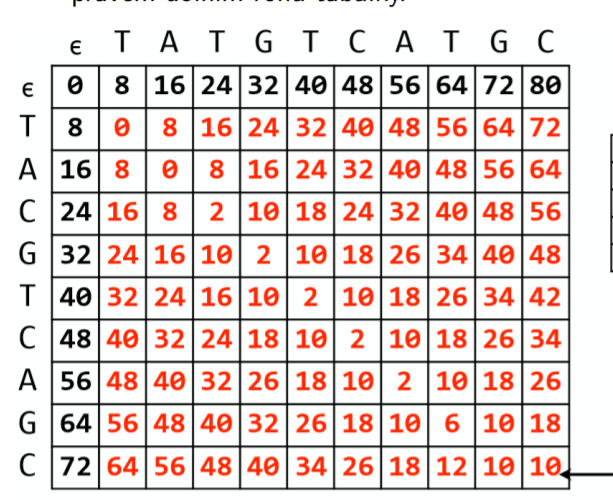

# Implementujte lokální alignment - vyzkoušejte pro ukázkové sekvence z přednášky

- Implementace backtrackingu není povinná

In [12]:
def create_local_pen_function(diagonal, other, i_d):
    size = len(ALPHABET) + 1
    k = ALPHABET+['-']
    pen = np.full((size, size), other)
    df = pd.DataFrame(pen, index=k, columns=k)
    
    pen[:, -1] = i_d
    pen[-1, :] = i_d
    
    np.fill_diagonal(pen, diagonal)
    
    return df

In [13]:
pen_local = create_local_pen_function(2, -4, -6)
pen_local

,A,C,G,T,-
A,2,-4,-4,-4,-6
C,-4,2,-4,-4,-6
G,-4,-4,2,-4,-6
T,-4,-4,-4,2,-6
-,-6,-6,-6,-6,2


In [14]:
y = 'TATATGCGGCGTTT'
x = 'GGTATGCTGGCGCTA'
M, m = edit_distance(x, y, formula_calc, init_local, pen_local, False, True);
pd.DataFrame(M, index=(['e']+list(x)), columns=(['e'] + list(y)))

,e,T,A,T,A,T,G,C,G,G,C,G,T,T,T
e,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
G,0,0,0,0,0,0,2,0,2,2,0,2,0,0,0
G,0,0,0,0,0,0,2,0,2,4,0,2,0,0,0
T,0,2,0,2,0,2,0,0,0,0,0,0,4,2,2
A,0,0,4,0,4,0,0,0,0,0,0,0,0,0,0
T,0,2,0,6,0,6,0,0,0,0,0,0,2,2,2
G,0,0,0,0,2,0,8,2,2,2,0,2,0,0,0
C,0,0,0,0,0,0,2,10,4,0,4,0,0,0,0
T,0,2,0,2,0,2,0,4,6,0,0,0,2,2,2
G,0,0,0,0,0,0,4,0,6,8,2,2,0,0,0


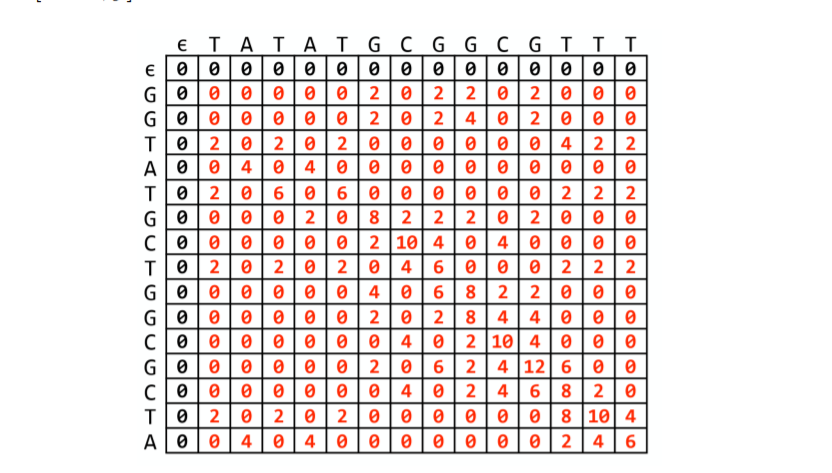

# Implementujte semiglobální alignment

In [15]:
def create_semiglobal_pen_function(true, false, indel):
    size = len(ALPHABET) + 1
    k = [i.lower() for i in ALPHABET+['-']]
    pen = np.zeros(shape=(size, size))
    df = pd.DataFrame(pen, index=k, columns=k)

    for i in range(size):
        for j in range(size):
            if i == j:
                pen[i, j] = true
            else:
                pen[i, j] = false
                    
        
    pen[:, -1] = indel
    pen[-1, :] = indel
    
    return df

## Penalizační funkce

In [16]:
pen_semiglobal = create_semiglobal_pen_function(1, -1, -2)
pen_semiglobal

,a,c,g,t,-
a,1.0,-1.0,-1.0,-1.0,-2.0
c,-1.0,1.0,-1.0,-1.0,-2.0
g,-1.0,-1.0,1.0,-1.0,-2.0
t,-1.0,-1.0,-1.0,1.0,-2.0
-,-2.0,-2.0,-2.0,-2.0,-2.0


## Načtení chromozomu

In [17]:
def load_chromozome(path):
    chr17 = ''
    with open(path, 'r') as f:
        chr17 = f.readlines()
        chr17 = chr17[1:]
        chr17 = [l.replace('\n', '').lower() for l in chr17]
    return ''.join(chr17)

In [18]:
path = f'.\data\chr17\chr17.fa'
ref = load_chromozome(path)

## Načtení fastq

In [19]:
def find_all(text):
    seq = []
    while True:
        f_t = 'N:0:52'
        s_t = '+'
        len_f = len(f_t) 
        len_s = len(s_t)
        f = text.find(f_t)
        s = text.find(s_t)
        if f == -1 or s == -1:
            break
        seq.append(text[f+len_f:s])
        text = text[s+len_s:]
    return seq

In [20]:
def load_fastq(path):
    with open(path, 'r') as f:
        lines = f.readlines()
        lines = [l.replace('\n', '') for l in lines]
        text = ''.join(lines)
        return find_all(text)

In [21]:
path_r1 = f'.//data//fastq//fastq_R1.fastq'

In [22]:
path_r2 = f'.//data//fastq//fastq_R2.fastq'

In [23]:
r1 = load_fastq(path_r1)
r1

['CTTTCCACTTGATAAGAGGTCCCAAGACTTAGTACCTGGAGGGTGAAATATTCTCCATCCAGTGGTTTCTTCTTTGGCTGGGGAGAGGAGCTGGTGTTGTTGGGCAGTGCTAGGAAAGAGGCAAGGAAAGGTGATAAAAGTGAATCTGAGG',
 'CTTTCCACTTGATAAGAGGTCCCAAGACTTAGTACCTGAAGGGTGAAATATTCTCCATCCAGTGGTTTCTTCTTTGGCTGGGGAGAGGAGCTGGTGTTGTTGGGCAGTGCTAGGAAAGAGGCAAGGAAAGGTGATAAAAGTGAATCTGAGG',
 'CAGGACTGCTCGAGCCGGGGAGGCAAAGGCTGCAGTAAGCCAAGATCACGCCACTCCACTCCAGCCTGGGCAACAAAGCGAGACCCAGTCTCAAAGAAAAAGAAAAAAAAAAAAAAAAGAAAAAAGAAATTGACCCTGAGCATAAAACAAG']

In [24]:
r2 = load_fastq(path_r2)
r2

['TAAGCAAGCAGGACAAGAAGCGGTGGAGGAGACCAAGGGTGCAGTTATGCCTCAGATTCACTTTTATCACCTTTCCTTGCCTCTTTCCTAGCACTGCCCAACAACACCAGCTCCTCTCCCCAGCCAAAGAAGAAACCACTGGATGGAGAAT',
 'TAAGCAAGCAGGACAAGAAGCGGTGGAGGAGACCAGGGTGCGGTTATGCCTCAGATTCACTTTTATCACCTTTCCTTGCCTCTTTCCTAGCACTGCCCAACAACACCAGCTCCTCTCCCCAGCCAAAGAAGAAACCACTGGATGGAGAATA',
 'CCTGGAGGATTTCATCTCTTGTATATGATGATCTGGATCCACCAAGACTTGTTTTATGCTCAGGGTCAATTTCTTTTTTCTTTTTTTTTTTTTTTTCTTTTTCTTTGAGACTGGGTCTCGCTTTGTTGCCCAGGCTGGAGTGGAGTGGCGT']

In [25]:
def complement(seq):
    return seq.translate(str.maketrans({'T': 'A', 'A': 'T', 'G': 'C', 'C': 'G'}))

In [26]:
def reverse(seq):
    return seq[::-1]

- Při parsování zanechat N... bude se to chovat jako zaměna
- Udělat všechno velké a všechno malé
- R1 normálně přímo vyčíst
- R2 ... ATTCGTT.. naopak zezadu ATTCTCCAT ... komplementárně
- Najít pozici sekvence

In [27]:
complement(reverse("ATGGAGAAT"))

'ATTCTCCAT'

## Ready R1

In [28]:
r1

['CTTTCCACTTGATAAGAGGTCCCAAGACTTAGTACCTGGAGGGTGAAATATTCTCCATCCAGTGGTTTCTTCTTTGGCTGGGGAGAGGAGCTGGTGTTGTTGGGCAGTGCTAGGAAAGAGGCAAGGAAAGGTGATAAAAGTGAATCTGAGG',
 'CTTTCCACTTGATAAGAGGTCCCAAGACTTAGTACCTGAAGGGTGAAATATTCTCCATCCAGTGGTTTCTTCTTTGGCTGGGGAGAGGAGCTGGTGTTGTTGGGCAGTGCTAGGAAAGAGGCAAGGAAAGGTGATAAAAGTGAATCTGAGG',
 'CAGGACTGCTCGAGCCGGGGAGGCAAAGGCTGCAGTAAGCCAAGATCACGCCACTCCACTCCAGCCTGGGCAACAAAGCGAGACCCAGTCTCAAAGAAAAAGAAAAAAAAAAAAAAAAGAAAAAAGAAATTGACCCTGAGCATAAAACAAG']

## Ready R2

In [29]:
r2 = [complement(reverse(r)) for r in r2]

In [30]:
r2

['ATTCTCCATCCAGTGGTTTCTTCTTTGGCTGGGGAGAGGAGCTGGTGTTGTTGGGCAGTGCTAGGAAAGAGGCAAGGAAAGGTGATAAAAGTGAATCTGAGGCATAACTGCACCCTTGGTCTCCTCCACCGCTTCTTGTCCTGCTTGCTTA',
 'TATTCTCCATCCAGTGGTTTCTTCTTTGGCTGGGGAGAGGAGCTGGTGTTGTTGGGCAGTGCTAGGAAAGAGGCAAGGAAAGGTGATAAAAGTGAATCTGAGGCATAACCGCACCCTGGTCTCCTCCACCGCTTCTTGTCCTGCTTGCTTA',
 'ACGCCACTCCACTCCAGCCTGGGCAACAAAGCGAGACCCAGTCTCAAAGAAAAAGAAAAAAAAAAAAAAAAGAAAAAAGAAATTGACCCTGAGCATAAAACAAGTCTTGGTGGATCCAGATCATCATATACAAGAGATGAAATCCTCCAGG']

# Semi-Global alignment

In [31]:
def run_semi(look, referential):
    transformed_ref =  referential.lower()
    transformed_look = look.lower()
    
    #print(transformed_ref)
    #print('\n')
    #print(transformed_look)
    
    M, m = edit_distance(transformed_look, transformed_ref, formula_calc, init_local, pen_semiglobal, False, True);
    df = pd.DataFrame(M, index=(['e']+list(transformed_look)), columns=(['e'] + list(transformed_ref)))
    
    max_index = np.argmax(M[-1, :])
    pos = (max_index-len(look), max_index)
    
    return M, m, df, pos

## Semi-global test

In [32]:
ref_test = ref.replace('n', '')
ref_test = ref_test[0:40]
ref_test

'gatcatgcagctcttccaggcccactgcttcttcctgtcc'

In [33]:
M, m, df, pos = run_semi('gat', ref_test)

In [34]:
pos

(0, 3)

In [35]:
df

,e,g,a,t,c,a,t,g,c,a,...,c,t,t,c,c,t,g,t,c,c
e,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
g,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
a,0,0,2,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
t,0,0,0,3,1,0,2,0,0,0,...,0,1,1,0,0,1,0,1,0,0


In [36]:
M

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 2, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 3, 1, 0, 2, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0]],
      dtype=int8)

## Semi-global real

In [37]:
t = np.zeros(shape=(2, len(ref)))

In [59]:
t.shape

(2, 83257441)

In [60]:
M, m, df, pos = run_semi(r1[0], ref);

ValueError: array is too big; `arr.size * arr.dtype.itemsize` is larger than the maximum possible size.

# Optimalization

In [38]:
def formula_calc_optimalization(M, row_i, col_i, x, y, pen, maximum=False):    
    x_char = x[row_i - 1]
    y_char = y[col_i - 1]
    
    x_exists = x_char in list(pen.index)
    y_exists = y_char in list(pen.columns)
    
    indel = pen.iloc[-1, -1]
    
    upper = M[(row_i - 1) % 2, col_i] + pen[x_char]['-'] if x_exists else indel
    left = M[(row_i) % 2, col_i - 1] + pen['-'][y_char] if y_exists else indel
    upper_left = M[(row_i - 1) % 2, col_i - 1] + pen[x_char][y_char] if x_exists and y_exists else indel
    
    value = np.max([upper, left, upper_left, 0]) if maximum else np.min([upper, left, upper_left])
    
    return value 

In [39]:
"""
    x - index string
    y - columns string
    init(matrix, pen_f)
    pen_f
"""
def edit_distance_optimalization(x, y, formula_calc, init=None, penalization_func=None, verbose=False, maximum=False, row=True):
    
    tic = time.time()
    
    l_a = len(x)
    l_b = len(y)
    
    e_l_a = l_a + 1
    e_l_b = l_b + 1
    
    M = np.zeros(shape=(2, e_l_b), dtype=np.int8)
    
    
    if verbose:
        print(f'Current input is:\n \n\tx={x}\n\ty={y}\n')
    
    
    #Doplníme hodnoty D[0, i] = i a D[j, 0] = j
    
    M = init(M, penalization_func, x, y)
        
    #Dle vyznačeného směru dopočítáme do tabulky hodnoty:
    max_v = (0, 0)
    for row_i in range(1, e_l_a):
        for col_i in range(1, e_l_b):
            value = formula_calc(M, row_i, col_i, x, y, penalization_func, maximum)     
            if value == 3:
                print(row_i, col_i, l_a)
            if col_i == l_a and value > max_v[1]:
                print(max_v)
                max_v = (row_i, value)
            M[row_i % 2, col_i] = value
    
    tac = time.time()
    
    runtime = tac - tic
    
    empty = list('e')
    indicies = empty+list(x)
    columns = empty+list(y)
    
    return (M, runtime, max_v)

In [40]:
def run_semi_optimalization(look, referential):
    transformed_ref =  referential.lower()
    transformed_look = look.lower()
    
    M, m, max_v = edit_distance_optimalization(transformed_look, transformed_ref, formula_calc_optimalization, init_local, pen_semiglobal, False, True);
    df = pd.DataFrame(M, columns=(['e'] + list(transformed_ref)))
    
    max_index = np.argmax(M[-1, :])
    pos = (max_index-len(look), max_index)
    
    return M, m, df, pos

In [41]:
M, m, df, pos = run_semi_optimalization('gat', ref_test)

3 3 3
(0, 0)


In [42]:
df

,e,g,a,t,c,a,t,g,c,a,...,c,t,t,c,c,t,g,t,c,c
0,0,0,2,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,3,1,0,2,0,0,0,...,0,1,1,0,0,1,0,1,0,0


In [43]:
M, m, df, pos = run_semi_optimalization(ref_test, 'gat')

3 3 40


In [44]:
df

,e,g,a,t
0,0,0,0,0
1,0,0,0,0


# Volitelně: naimplementujte paralelní výpočet u globálního a lokálního alignmentu. [NOPE!]

...